# Borrower reliability research

## Getting data

In [1]:
import pandas as pd
import os
import sweetviz as sv
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

path1 = r'C:\Users\exeve\Downloads\data.csv'
path2 = '/datasets/data.csv'

try:
    if os.path.exists(path1):
        data = pd.read_csv(path1)
    elif os.path.exists(path2):
        data = pd.read_csv(path2)
except:
    print('Something went wrong')

## Data overview

                                             |                                             | [  0%]   00:00 ->…


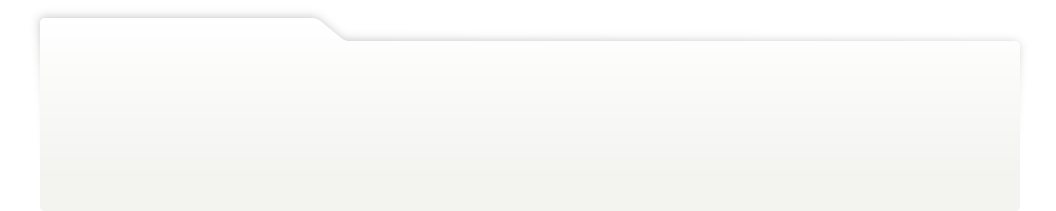
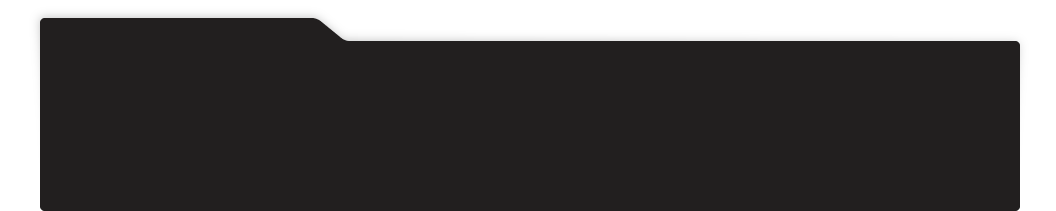
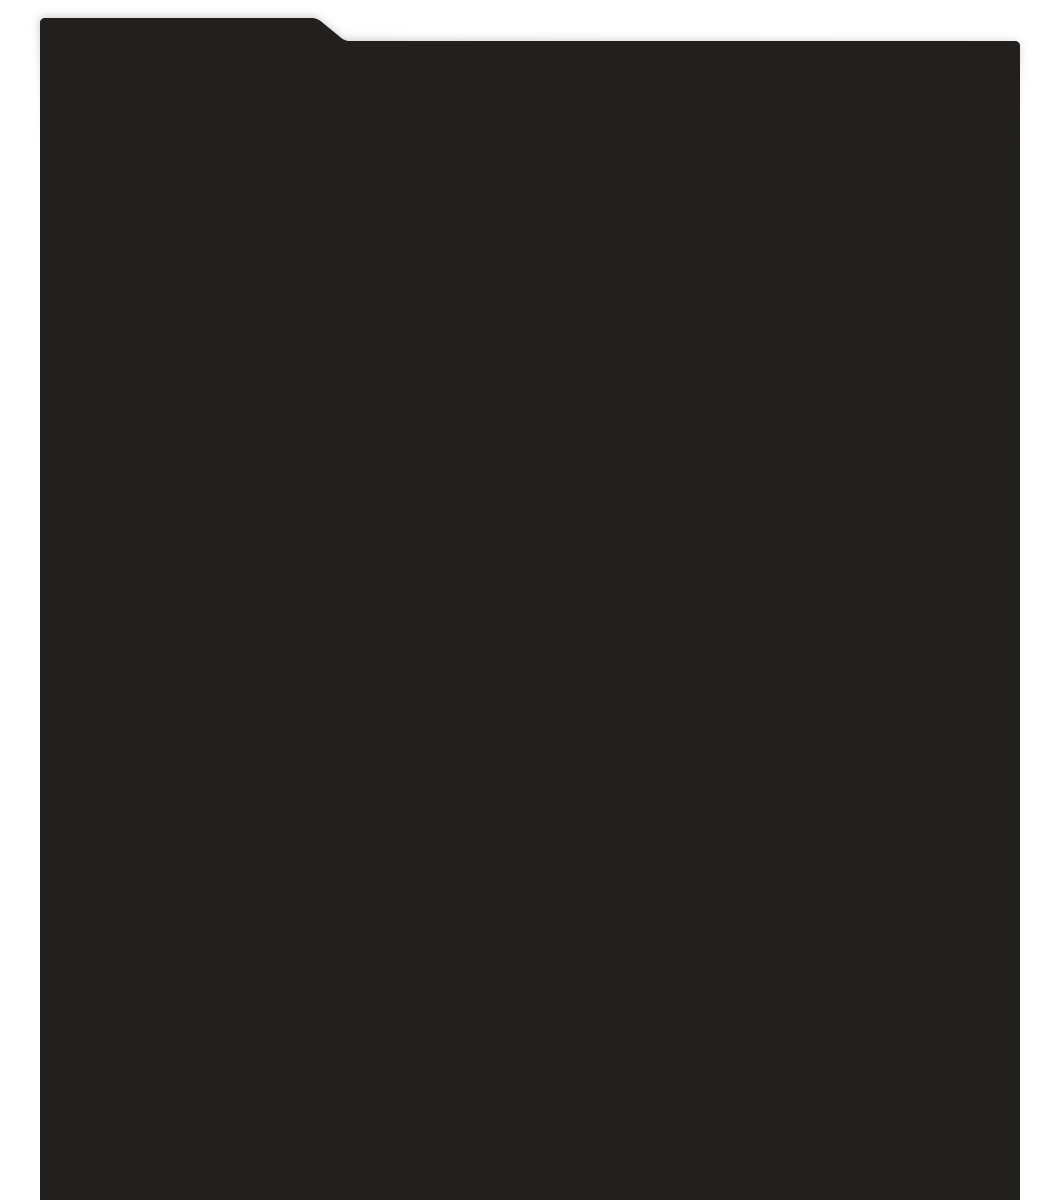
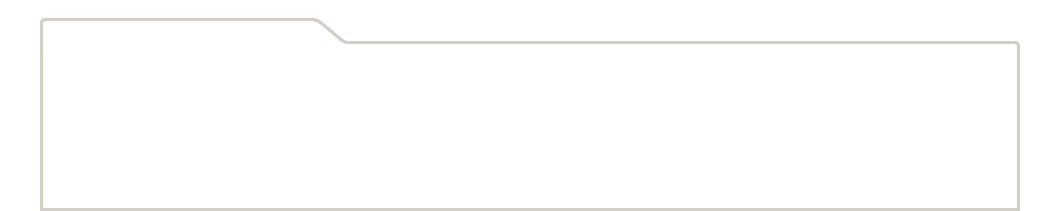
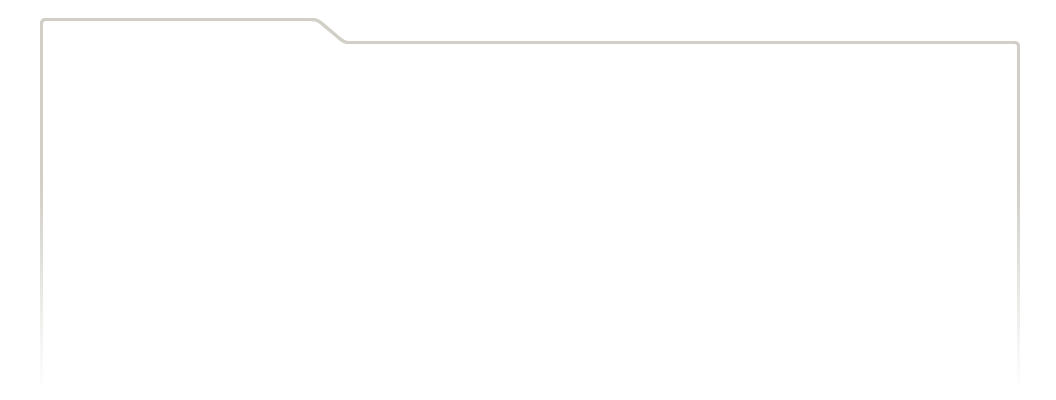
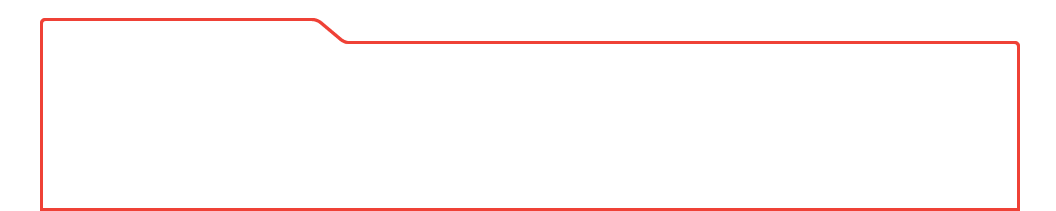
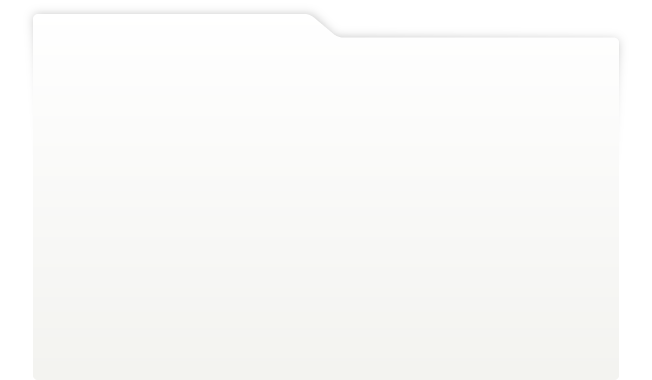
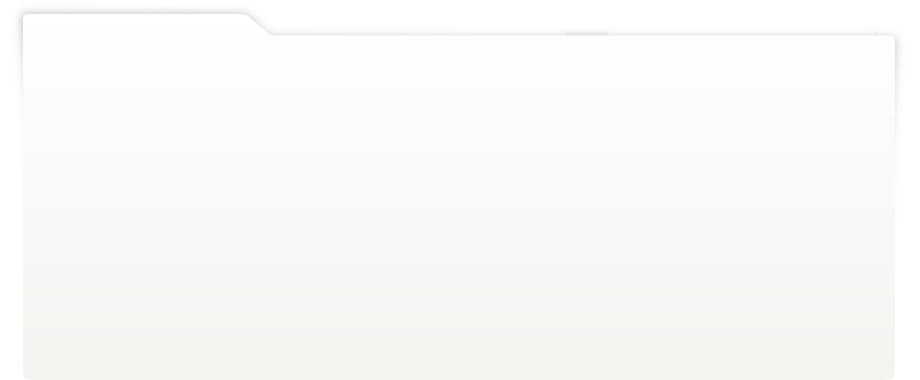
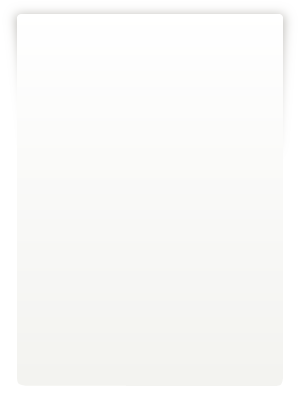
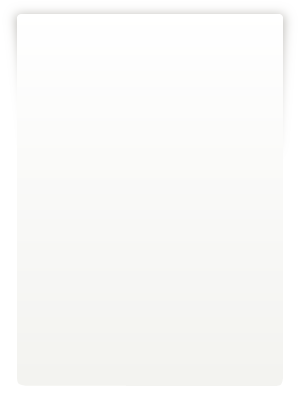
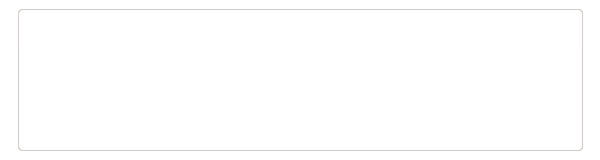
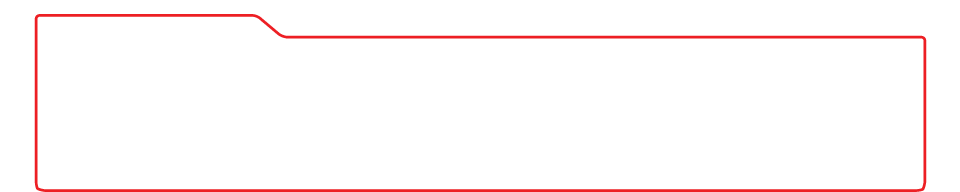
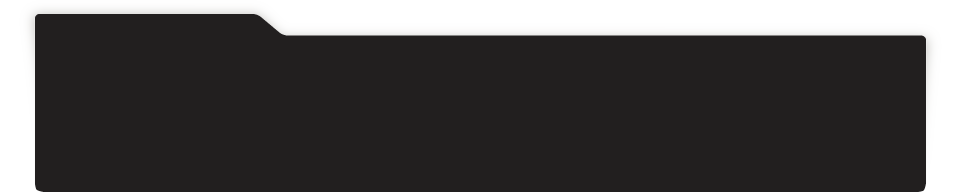
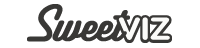
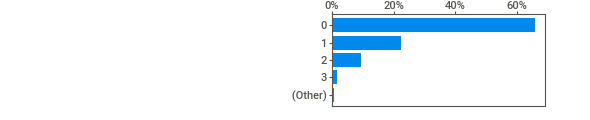
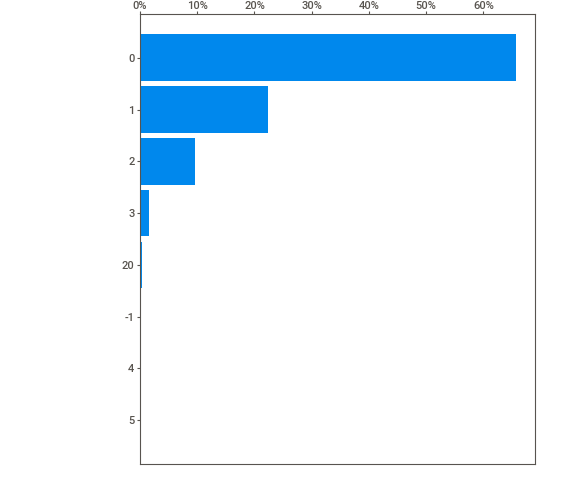
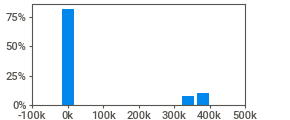
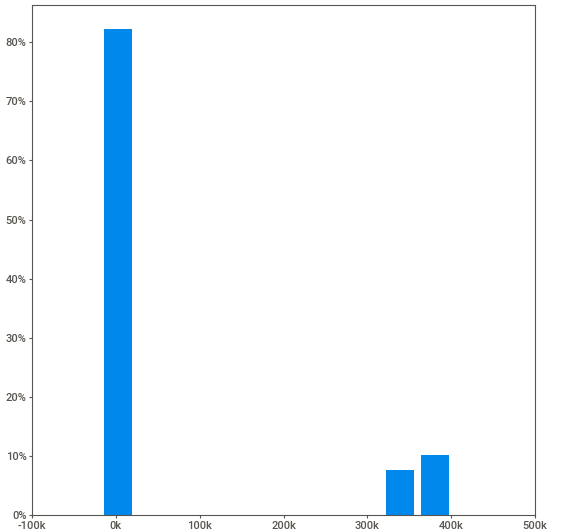
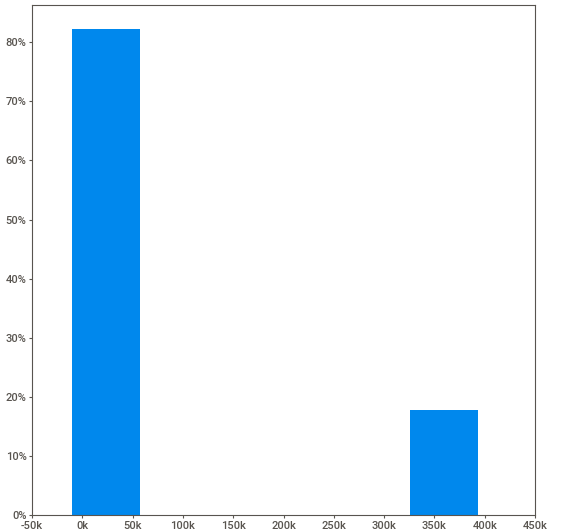
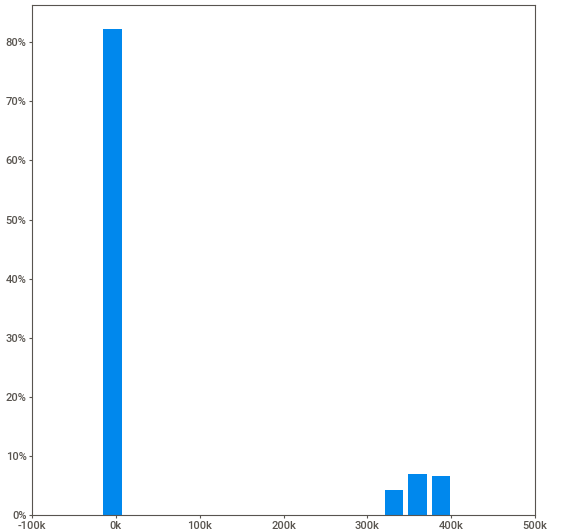
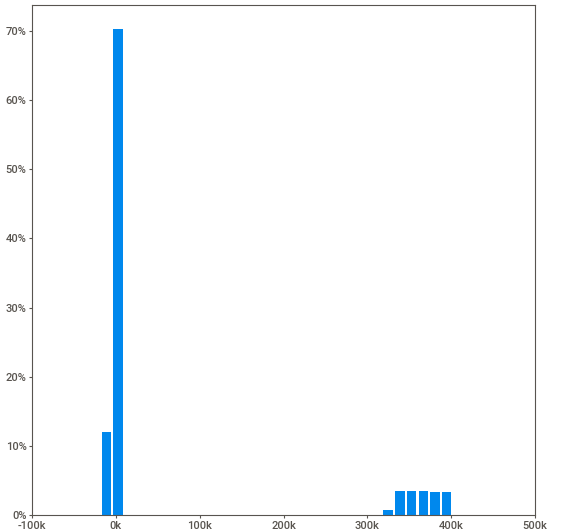
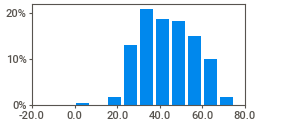
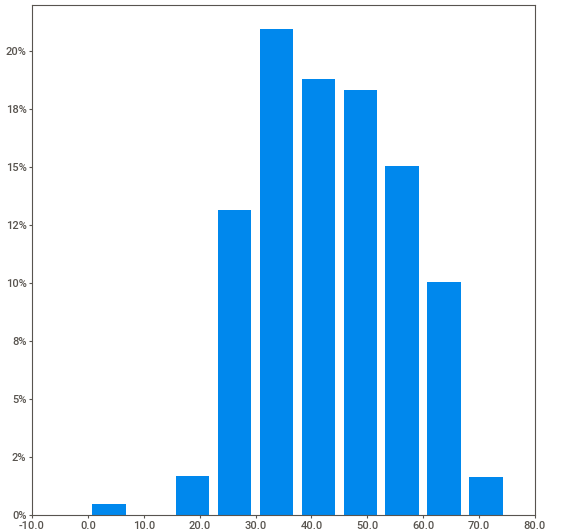
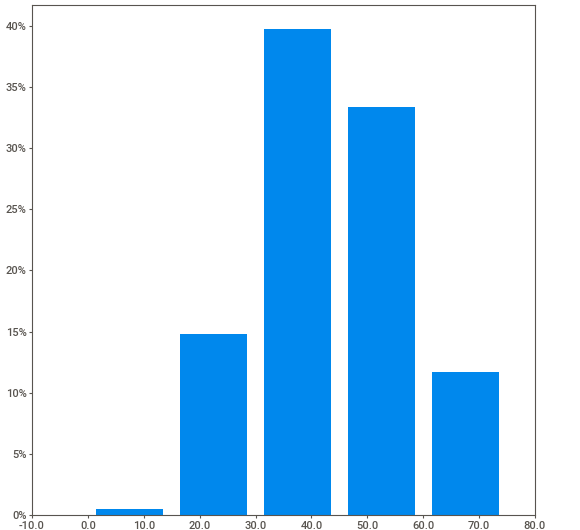
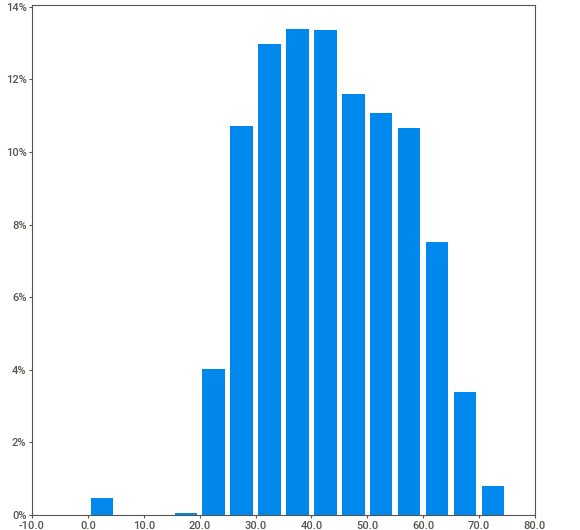
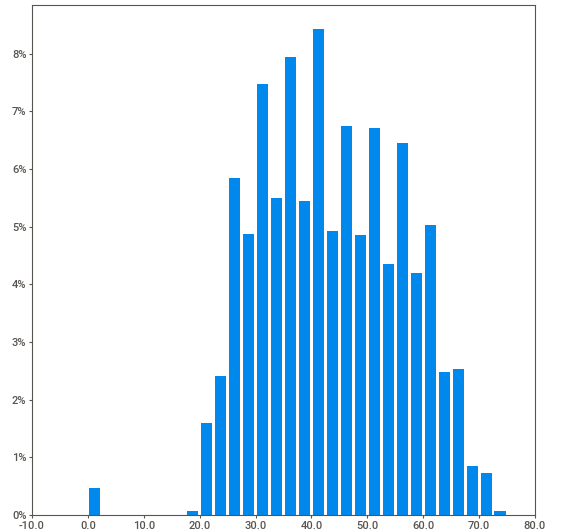
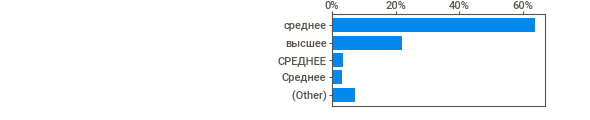
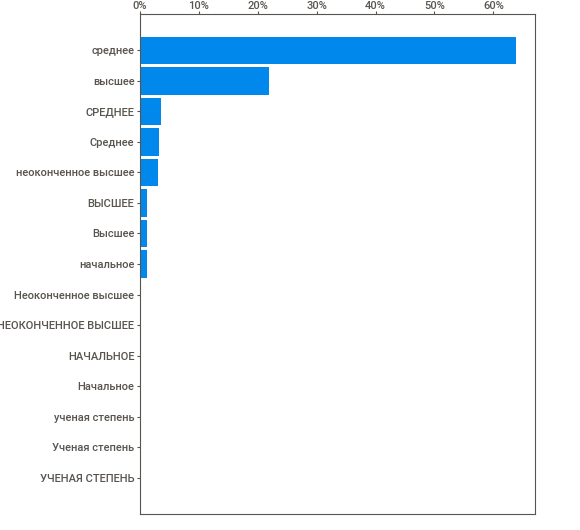
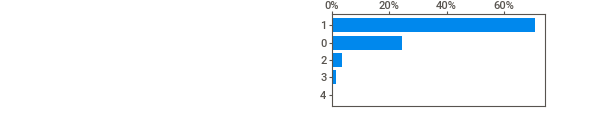
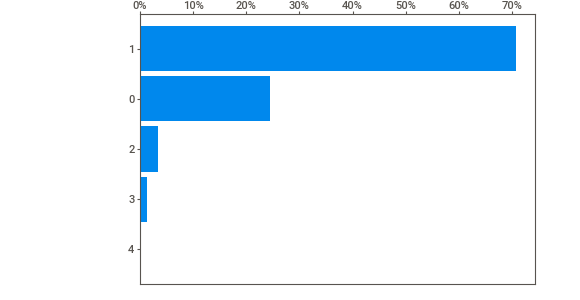
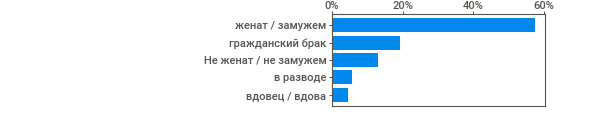
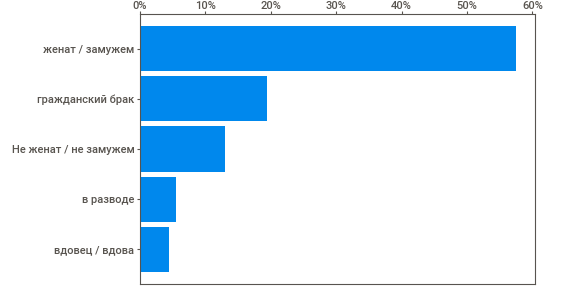
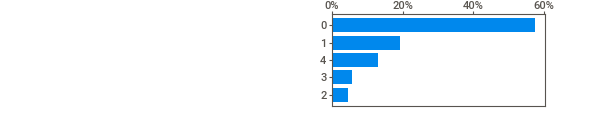
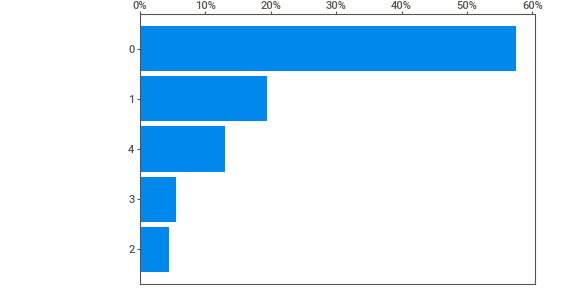
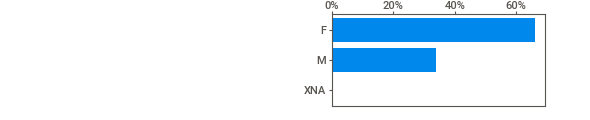
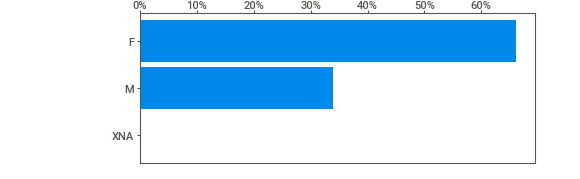
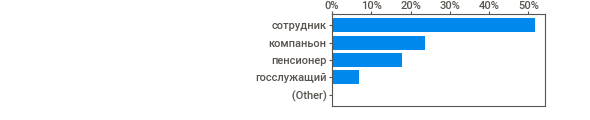
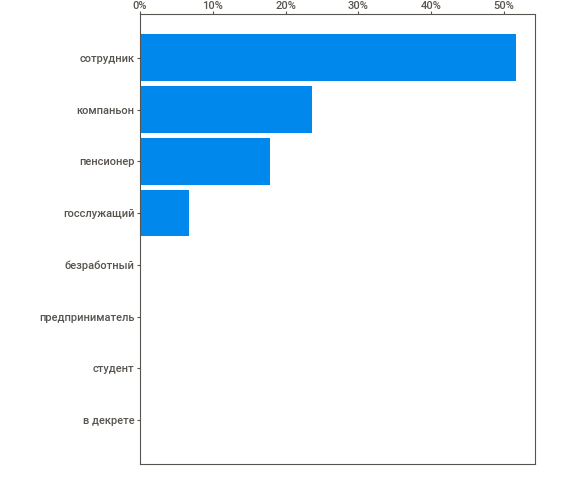
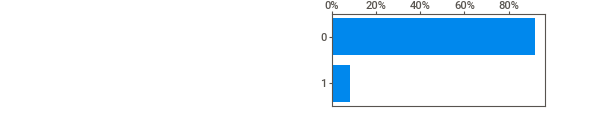
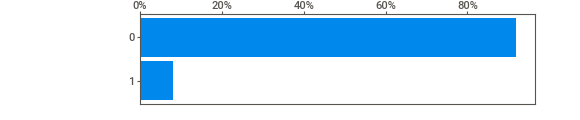
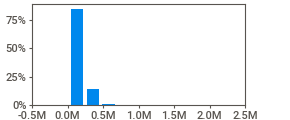
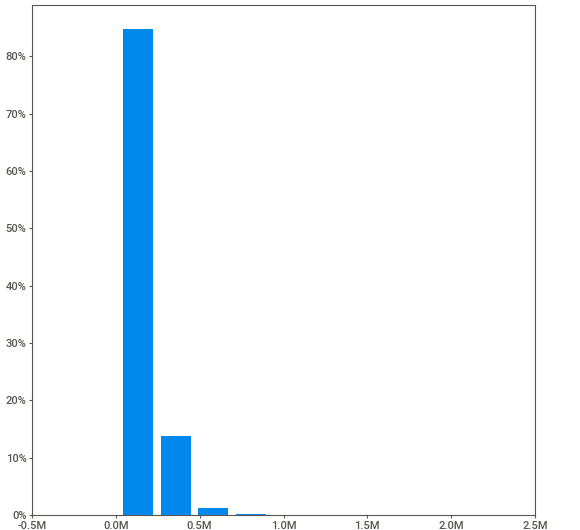
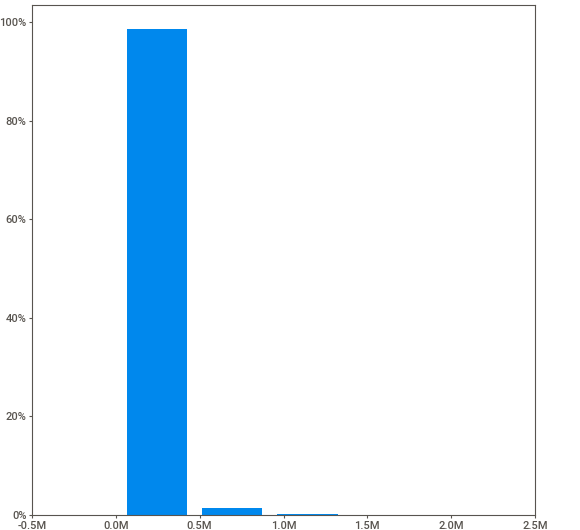
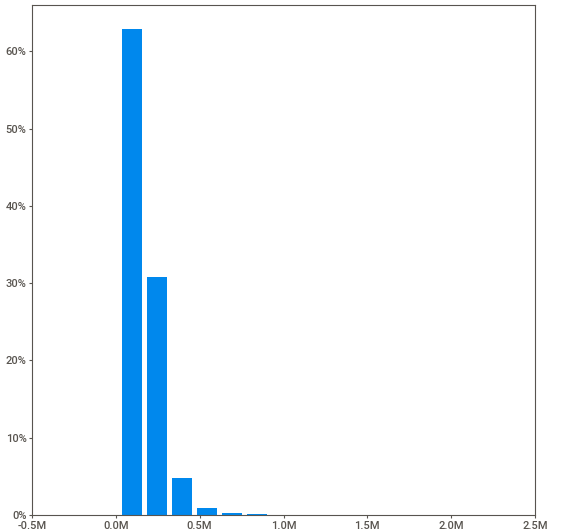
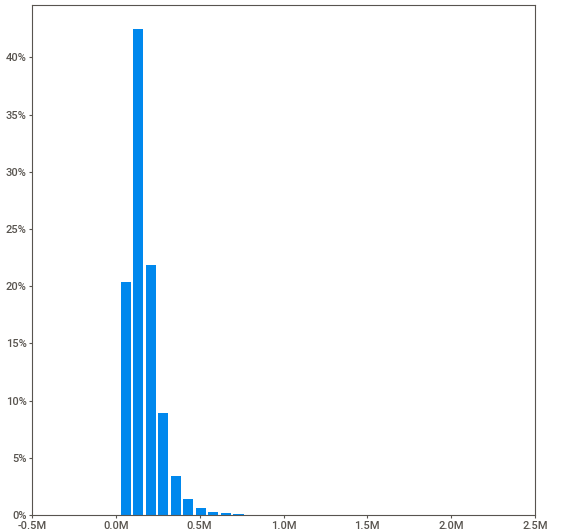
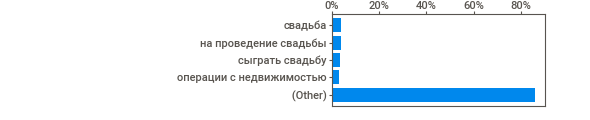
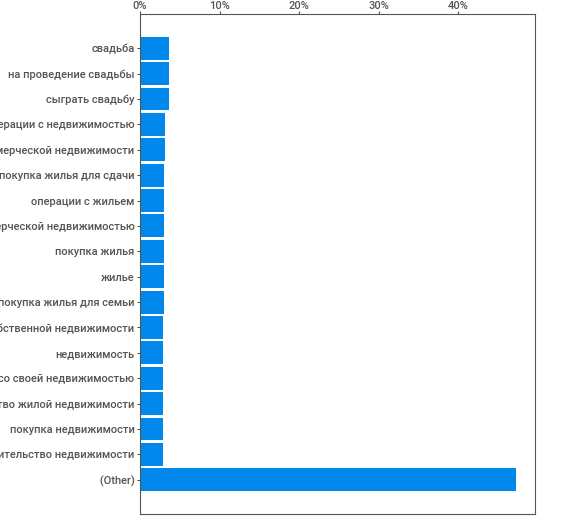
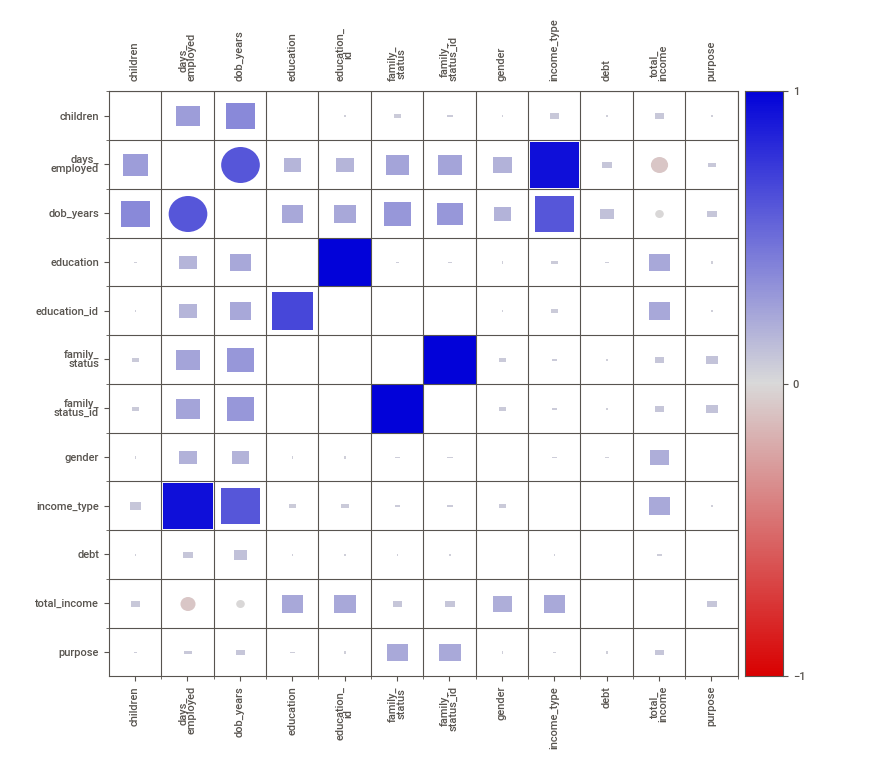
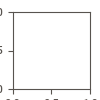

In [2]:
report = sv.analyze(data)
report.show_notebook()

## Preprocessing

### Missing values

- Two features have missing values. One of them is `days_employed`. The other one, `total_income`, which stores income data. The amount of income is most influenced by the type of employment, so we need to fill in the gaps in this column with the median value for each type from the `income_type` column:

In [3]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()


- The `days_employed` column contains negative values, which can be considered anomalous, since days cannot be negative. We will replace all negative values with positive values converting them into absolute values. Then we will fill the gaps in with the median value of the employment days corresponding to each income type:

In [4]:
data['days_employed'] = data['days_employed'].abs()

for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [5]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Duplicates

In [6]:
data.duplicated().sum()

54

- Dropping the 54 duplicates:

In [7]:
data = data.drop_duplicates()

- The `education` column contains repeated values, but written differently, using uppercase and lowercase letters. We will convert them into lowercase to unify the categories:

In [8]:
data['education'] = data['education'].str.lower()

### Data types

Cents are negligible in our case, so we will convert the income into integer values:

In [9]:
data['total_income'] = data['total_income'].astype(int)

### Anomalies

#### Translating income_type categories into english

In [10]:
data['income_type'] = data['income_type'].str.replace('безработный', 'unemployed', regex=True)
data['income_type'] = data['income_type'].str.replace('в декрете', 'on maternity leave', regex=True)
data['income_type'] = data['income_type'].str.replace('госслужащий', 'civil servant', regex=True)
data['income_type'] = data['income_type'].str.replace('компаньон', 'activity partner', regex=True)
data['income_type'] = data['income_type'].str.replace('предприниматель', 'entrepreneur', regex=True)
data['income_type'] = data['income_type'].str.replace('сотрудник', 'employee', regex=True)
data['income_type'] = data['income_type'].str.replace('студент', 'student', regex=True)
data['income_type'] = data['income_type'].str.replace('пенсионер', 'pensioner', regex=True)

data['income_type'].unique()

array(['employee', 'pensioner', 'activity partner', 'civil servant',
       'unemployed', 'entrepreneur', 'student', 'on maternity leave'],
      dtype=object)

- The `days_employed` feature contains some abnormal values in the range from 300k to 400k days employed. Let's have a look at the median value of work experience `days_employed` in days for each type of employment:

In [11]:
income_days = data.groupby('income_type')['days_employed'].agg('median')
income_days

income_type
activity partner        1547.382223
civil servant           2689.368353
employee                1574.202821
entrepreneur             520.848083
on maternity leave      3296.759962
pensioner             365213.306266
student                  578.751554
unemployed            366413.652744
Name: days_employed, dtype: float64

We can see that pensioners and the unemployed have some outlying values. Let's see how much that is in years to better understand how great the discrepancy is:

In [12]:
data_test = data
data_test['years_employed'] = data['days_employed'] / 365
display(data_test['years_employed'].head())
income_years = data_test.groupby('income_type')['years_employed'].agg('median')

0     23.116912
1     11.026860
2     15.406637
3     11.300677
4    932.235814
Name: years_employed, dtype: float64

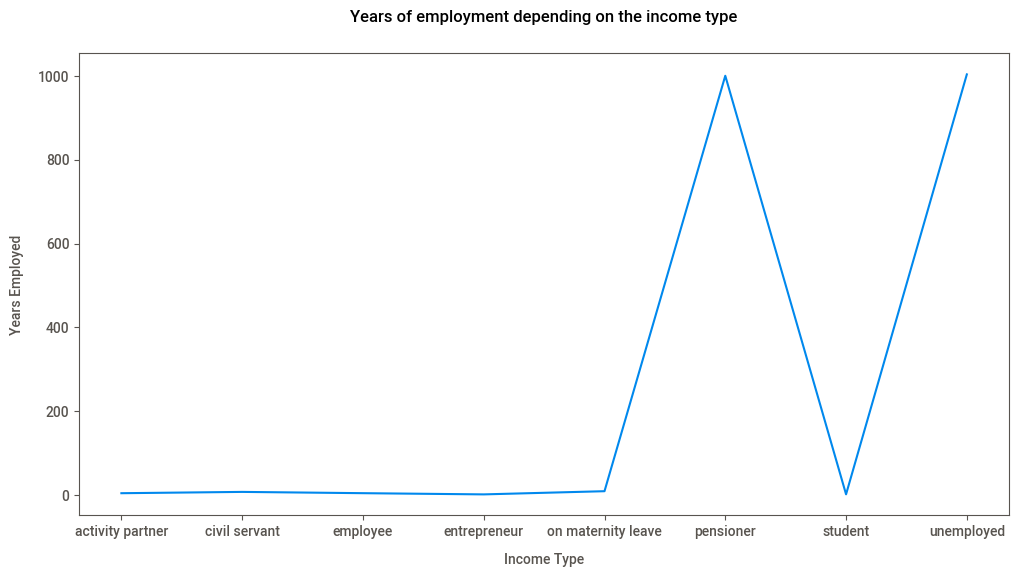

In [13]:
plt.figure(figsize=(12,6))
plt.title('Years of employment depending on the income type', y = 1.05)
income_years.plot()
plt.ylabel('Years Employed', labelpad=10)
plt.xlabel('Income Type', labelpad=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

A thousand years of work. That does not seem too realistic. Let's check the pensioners and the unemployed separately.

#### Studying anomalous values for pensioners employment days

In [14]:
pensioners_employed = pd.DataFrame(data_test.loc[data_test['income_type'] == 'pensioner', 'years_employed'], 
                                columns = ['years_employed'])
pensioners_employed.describe()


,years_employed
count,3837.000000
mean,1000.068592
std,54.680427
min,900.626632
25%,955.369841
50%,1000.584401
75%,1043.421345
max,1100.699727


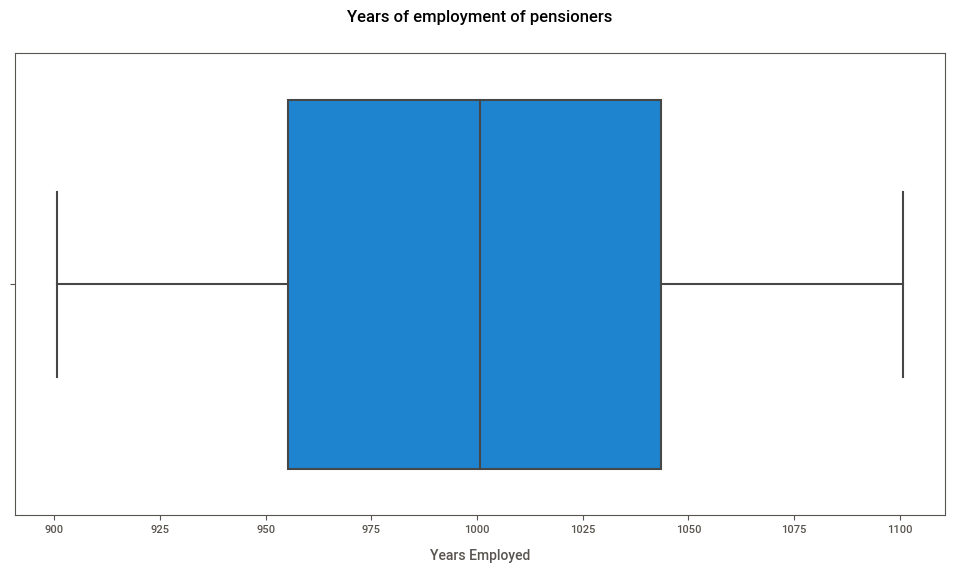

In [15]:
plt.figure(figsize=(12,6))
plt.title('Years of employment of pensioners', y = 1.05)
sns.boxplot(pensioners_employed, x = 'years_employed')
plt.xlabel('Years Employed', labelpad=10)
plt.show()

#### Studying anomalous values for the unemployed employment days

In [16]:
unemployed_employed = pd.DataFrame(data_test.loc[data_test['income_type'] == 'unemployed', 'years_employed'], 
                                columns = ['years_employed'])
unemployed_employed.describe()

,years_employed
count,2.000000
mean,1003.873021
std,111.932818
min,924.724567
25%,964.298794
50%,1003.873021
75%,1043.447248
max,1083.021476


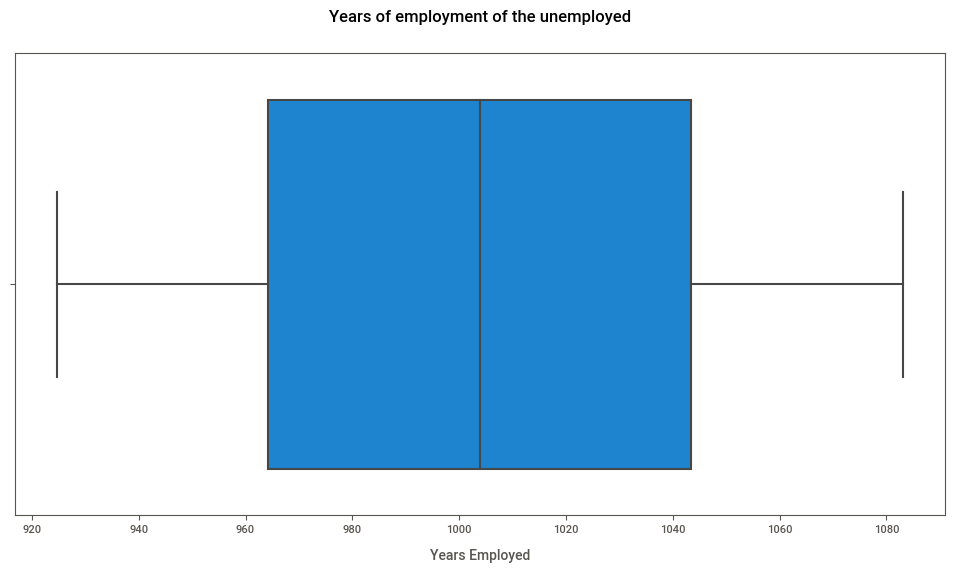

In [17]:
plt.figure(figsize=(12,6))
plt.title('Years of employment of the unemployed', y = 1.05)
sns.boxplot(unemployed_employed, x = 'years_employed')
plt.xlabel('Years Employed', labelpad=10)
plt.show()

Both categories (pensioners and unemployed) lack normal values and mostly have extreme values. It is probably due to an error when filling in the data or when joining the data tables. These are also the two categories that banks usually refuse to give credit due to lack of guarantee of repayment due to age and lack of income. In any case, days worked is not a factor that is relevant for our analysis.

### The 'children' feature contains some unreasonable values

In [18]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

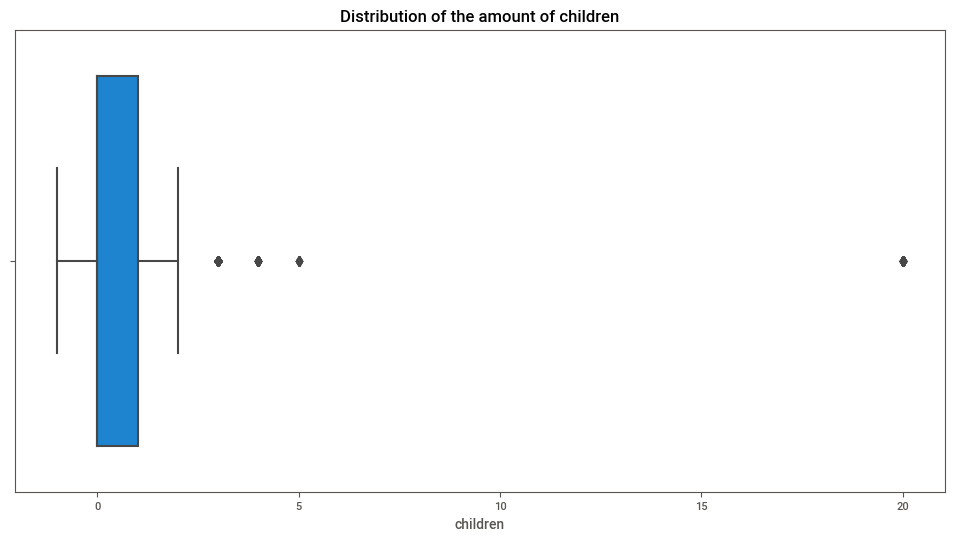

In [19]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the amount of children')
sns.boxplot(data=data, x = 'children')
plt.show()

- The amount of children cannot be negative. Also, 20 children is cleary an outlier, so we're removing it too. 

In [20]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

## Data categorization

### Income categorization

**Let's split the type of income into categories for convenience. We'll store the category in the `total_income_category` column.**

These will be the categories depending on the income range:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 and above — `'A'`.

In [21]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [22]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

### Purpose categorization

In [23]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

There are too many purpose categories, but we can group them up into a few summarizing categories for convenience. Mostly, the purposes have to do with car operations, real estate operations, weddings or education. So these will be our four main categories.

In [24]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'car operations'
        elif 'жил' in row or 'недвиж' in row:
            return 'real estate transactions'
        elif 'свад' in row:
            return 'holding a wedding'
        elif 'образов' in row:
            return 'getting an education'
    except:
        return 'no category'

In [25]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Analysis
**Let's analyze the different possible factors that might affect the repayment of the loan on time**

#### A little function to calculate percentages

In [26]:
def percentage(x): 
    return '{0:.2%}'.format(x)

### Number of children

In [27]:
children_debt_dependency = data.groupby(['children']).agg({'debt' : ['sum', 'count', 'mean']})
children_debt_dependency.columns = children_debt_dependency.columns.droplevel(0)
children_debt_dependency.columns =  [ 'Debtors', 'Total', 'Debtors %']
children_debt_dependency = children_debt_dependency.rename_axis('Children').sort_values(by='Debtors %', ascending=False)
children_debt_dependency['Debtors %'] = children_debt_dependency['Debtors %'].apply(percentage)
children_debt_dependency

,Debtors,Total,Debtors %
Children,,,
4,4,41,9.76%
2,194,2052,9.45%
1,444,4809,9.23%
3,27,330,8.18%
0,1063,14107,7.54%
5,0,9,0.00%


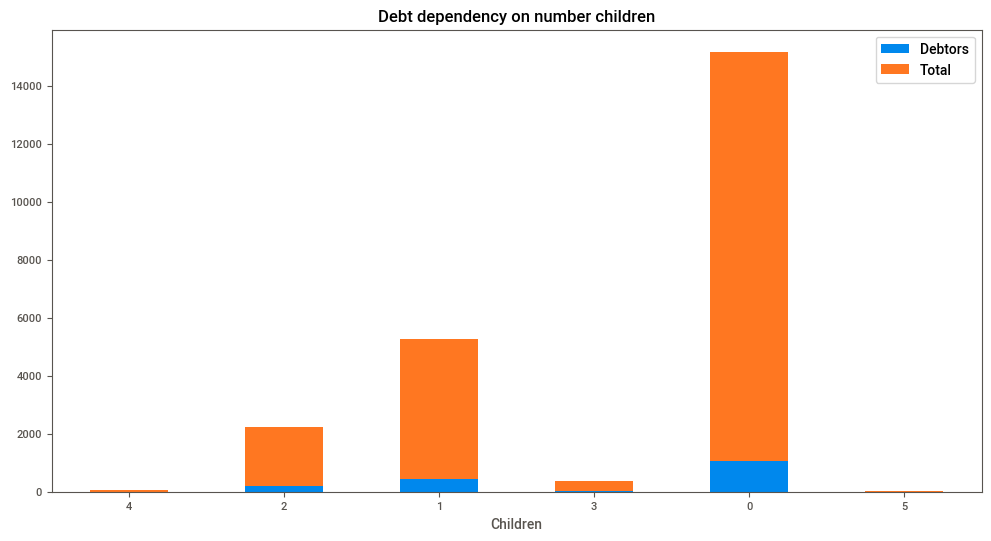

In [28]:
children_debt_dependency.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Debt dependency on number children')
plt.xticks(rotation=0)
plt.show()

**Conclusion:**

- People with no children are the best at repaying loans. The share of debtors here is 7.54%.
- The situation is worse with debtors who have one or two children, the share of non-repayment is 9.23% and 9.45% here, respectively.
- It is not correct to compare the remaining categories, since they have a very small sample.

The difference between the average maximum (9.45%) and average minimum (7.54%) values of debtors is 20.21%

### Family status 

#### Translating family_status categories into english

In [29]:
data['family_status'] = data['family_status'].str.replace('Не женат / не замужем', 'single', regex=True)
data['family_status'] = data['family_status'].str.replace('гражданский брак', 'civil marriage', regex=True)
data['family_status'] = data['family_status'].str.replace('женат / замужем', 'married', regex=True)
data['family_status'] = data['family_status'].str.replace('в разводе', 'divorced', regex=True)
data['family_status'] = data['family_status'].str.replace('вдовец / вдова', 'widower / widow', regex=True)



data['family_status'].unique()

array(['married', 'civil marriage', 'widower / widow', 'divorced',
       'single'], dtype=object)

#### Study

In [30]:
family_status_debt_dependency = data.groupby(['family_status']).agg({'debt':['sum','count','mean']})
family_status_debt_dependency.columns = family_status_debt_dependency.columns.droplevel(0)
family_status_debt_dependency = family_status_debt_dependency.sort_values(by='mean', ascending=False)
family_status_debt_dependency['mean'] = family_status_debt_dependency['mean'].apply(percentage)
family_status_debt_dependency = family_status_debt_dependency.rename(columns={'sum':'Debtors','count':'Total', 'mean':'Debtors %'})
family_status_debt_dependency = family_status_debt_dependency.rename_axis('Family Status')
family_status_debt_dependency

,Debtors,Total,Debtors %
Family Status,,,
single,273,2796,9.76%
civil marriage,385,4146,9.29%
married,927,12266,7.56%
divorced,84,1189,7.06%
widower / widow,63,951,6.62%


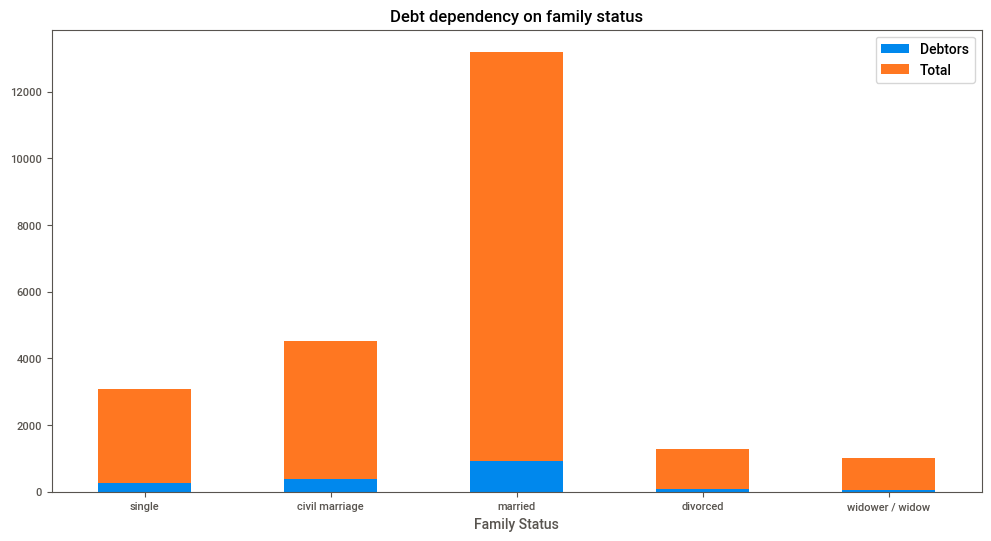

In [31]:
family_status_debt_dependency.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Debt dependency on family status')
plt.xticks(rotation=0)
plt.show()

**Conclusion:**

- People who are married are the best at repaying loans. The share of debtors here is 7.56%.
- The situation is worse with debtors who are single or in a civil marriage.
  Тhe share of non-return is 9.76% and 9.29% here, respectively.
- It is noт correct to compare the remaining categories, since they have a very small sample.

  The difference between the average maximum (9.76%) and average minimum (7.56%) values of debtors is 22.54%

### Income level

In [32]:
income_debt_dependency = data.groupby(['total_income_category']).agg({'debt':['sum','count','mean']})
income_debt_dependency.columns = income_debt_dependency.columns.droplevel(0)
income_debt_dependency = income_debt_dependency.sort_values(by='mean', ascending=False)
income_debt_dependency['mean'] = income_debt_dependency['mean'].apply(percentage)
income_debt_dependency = income_debt_dependency.rename(columns={'sum':'Debtors','count':'Total', 'mean':'Debtors %'})
income_debt_dependency = income_debt_dependency.rename_axis('Total income category')
income_debt_dependency

,Debtors,Total,Debtors %
Total income category,,,
E,2,22,9.09%
C,1353,15938,8.49%
A,2,25,8.00%
B,354,5014,7.06%
D,21,349,6.02%


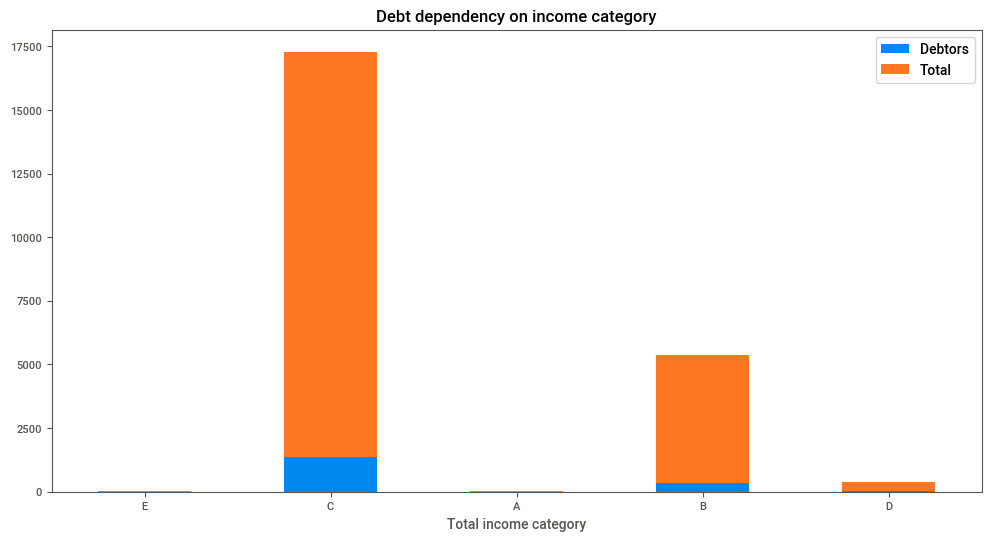

In [33]:
income_debt_dependency.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Debt dependency on income category')
plt.xticks(rotation=0)
plt.show()

**Conclusion:**
                    
- People with income category 'B' are the best at repaying loans. The share of debtors here is 7.06%.
- The situation is worse with debtors who have income category 'C'. The non-return rate is 8.50% here.
- It is not correct to compare the remaining categories, since they have a very small sample.

  The difference between the average maximum (8.50%) and average minimum (7.06%) values of debtors is 16.94%

### Loan purpose

In [34]:
purpose_debt_dependency = data.groupby(['purpose_category']).agg({'debt':['sum','count','mean']})
purpose_debt_dependency.columns = purpose_debt_dependency.columns.droplevel(0)
purpose_debt_dependency = purpose_debt_dependency.sort_values(by='mean', ascending=False)
purpose_debt_dependency['mean'] = purpose_debt_dependency['mean'].apply(percentage)
purpose_debt_dependency = purpose_debt_dependency.rename(columns={'sum':'Debtors','count':'Total', 'mean':'Debtors %'})
purpose_debt_dependency = purpose_debt_dependency.rename_axis('Purpose')
display(purpose_debt_dependency)

,Debtors,Total,Debtors %
Purpose,,,
car operations,400,4281,9.34%
getting an education,369,3989,9.25%
holding a wedding,183,2324,7.87%
real estate transactions,780,10754,7.25%


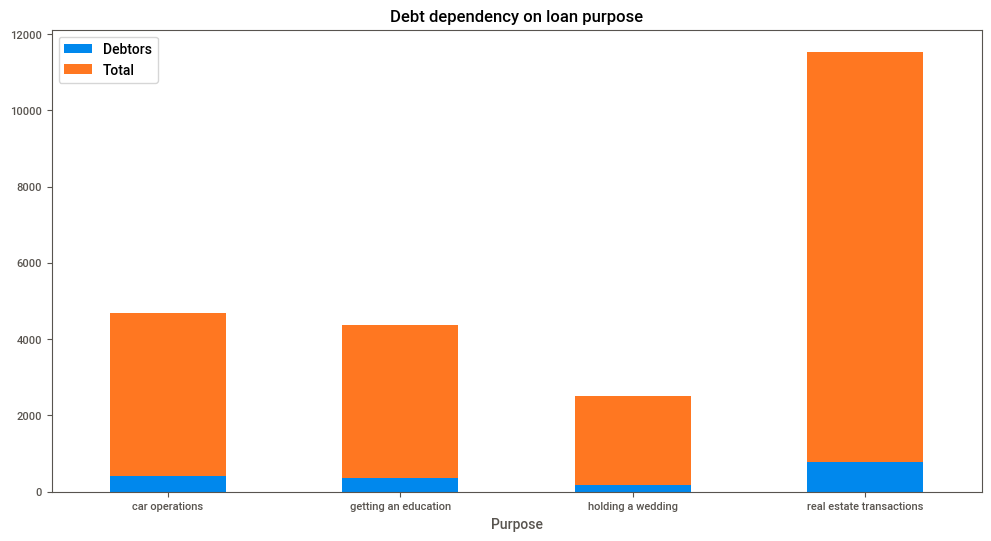

In [35]:
purpose_debt_dependency.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Debt dependency on loan purpose')
plt.xticks(rotation=0)
plt.show()

**Conclusion:**

- People whose loan purpose is "real estate transactions" are the best at repaying the loan, with a debt percentage of 7.25%.

- The worst debt repayers are those who take out a loan to buy cars or pay for studies, with debt rates of 9.35% and 9.25%, respectively (a difference of 1.07%).

- In the middle of the above categories are those who take out a loan to pay for weddings, with a debt percentage of 7.91%, But the sample cannot be considered large enough to draw conclusions.

  The difference between the average maximum (9.35%) and average minimum (7.26%) values of debtors is 22.35%


## General conclusion

In [36]:
# combining all the previous tables into one to see all the data together:

alltogether = [children_debt_dependency, family_status_debt_dependency ,income_debt_dependency, purpose_debt_dependency]
final_result = pd.concat(alltogether, keys = ['Children', 'Family Status', 'Total Income Category', 'Credit Goal'])
final_result

Debtors  Total Debtors %
Children              4                               4     41     9.76%
                      2                             194   2052     9.45%
                      1                             444   4809     9.23%
                      3                              27    330     8.18%
                      0                            1063  14107     7.54%
                      5                               0      9     0.00%
Family Status         single                        273   2796     9.76%
                      civil marriage                385   4146     9.29%
                      married                       927  12266     7.56%
                      divorced                       84   1189     7.06%
                      widower / widow                63    951     6.62%
Total Income Category E                               2     22     9.09%
                      C                            1353  15938     8.49%
                      A                               2     25     8.00%
                      B                             354   5014     7.06%
                      D                              21    349     6.02%
Credit Goal           car operations                400   4281     9.34%
                      getting an education          369   3989     9.25%
                      holding a wedding             183   2324     7.87%
                      real estate transactions      780  10754     7.25%

**CONCLUSIONS**:
 

- People with no children are the best at repaying loans. The share of debtors here is 7.54%. The situation is worse with debtors who have one or two children, the share of non-repayment is 9.23% and 9.45% here, respectively.

- People who are married are the best at repaying loans. The share of debtors here is 7.56%. The situation is worse with debtors who are single and those in a civil marriage. The share of non-return is 9.76% and 9.31% here, respectively.

- People with income category 'B' are the best at repaying loans. The share of debtors here is 7.06%. The situation is worse for debtors who have income category 'C'. The non-return rate is 8.50% here.

- People whose loan purpose is "real estate transactions" are the best at repaying the loan, with a debt percentage of 7.26%. The worst debt repayers are those who take out a loan to buy cars or pay for education, with debt percentages of 9.35% and 9.25%, respectively (a difference of 1.07%).


-------------------------------------------------- --------------------------

- This is the classification of the factors that most affect the non-payment of debts, from the greatest to the least:

    - Family status - 22.54% 
    - Loan goals - 22.35%
    - Number of children in the family - 20.21%
    - Income level - 16.94% 

The difference between family status and loan target is 0.84%
The difference between family status and number of children is 10.34%
The difference between family status and income level is 24.84%

That is, special attention should be paid to the family status of the borrowers, as well as their goals for the loan and the number of children.

In [37]:
# exporting the "data" dataframe to excel file
file_name = 'borrower_reliability_research.xlsx'
data.to_excel(file_name)